In [5]:
import pickle
import numpy as np
import h5py
import json
import sys
np.set_printoptions(threshold=sys.maxsize)
import seaborn as sns
import matplotlib.pylab as plt
import cv2
import os
from pathlib import Path


dataset_name = "SumMe"
# dataset_name = "TVSum"

model_score = pickle.load(
    open(f"./{dataset_name.lower()}_video_scores.pickle", "rb")
)

if dataset_name == "SumMe":
    video_path = "../../../data/SumMe/videos/"
elif dataset_name == "TVSum":
    video_path = "../../../data/tvsum50_ver_1_1/ydata-tvsum50-v1_1/ydata-tvsum50-video/video/"

data_path = (
    f"../data/{dataset_name}/eccv16_dataset_{dataset_name.lower()}_google_pool5.h5"
)
hdf = h5py.File(data_path, "r")  # Open hdf file


# TVSum: XzYM3PfTM4w
# SumMe: St Maarten Landing

splits = json.loads(
    open(f"../data/splits/{dataset_name.lower()}_splits.json", "r").read()
)


if dataset_name == "SumMe":
#     s = 2
    s = 2
elif dataset_name == "TVSum":
    s = 4

# keys = splits[s]["train_keys"]
keys = splits[s]["test_keys"]

# Get video name

video2index = {}
index2video = {}
frame2video = {}

for i, video_name in enumerate(keys):
    if dataset_name == "SumMe":
        video_full_name = np.array(hdf[video_name]["video_name"]).astype(str).tolist()
        video2index[video_full_name] = video_name 
        index2video[video_name] = video_full_name 
    elif dataset_name == "TVSum":        
        for key in list(hdf.keys()):
            nframes = int(np.array(hdf[key]["n_frames"]))
            frame2video[nframes] = key

        for video_full_name, data in model_score.items():
            video2index[video_full_name] = frame2video[data["summary"].shape[0]]
            index2video[frame2video[data["summary"].shape[0]]] = video_full_name


In [6]:
# print(model_score)
print(video2index)


{'Excavators river crossing': 'video_10', 'Kids_playing_in_leaves': 'video_13', 'St Maarten Landing': 'video_19', 'car_over_camera': 'video_23', 'Eiffel Tower': 'video_9'}


video: St Maarten Landing
0.1433466590519703
torch.Size([12, 12])
video name: St Maarten Landing video_19
num frames: 1751
changepoint: (12, 2)
user sum: (17, 1751)
attn weight 0: 12
attn diag:
0.16666558 0.166673 0.16668797 0.16667396 0.16665421 0.16666403 0.16665924 0.16666958 0.1666702 0.1666687 0.16666281 0.16664712 
attn weights: tensor([[0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.0000, 0.0000, 0.0000,
       

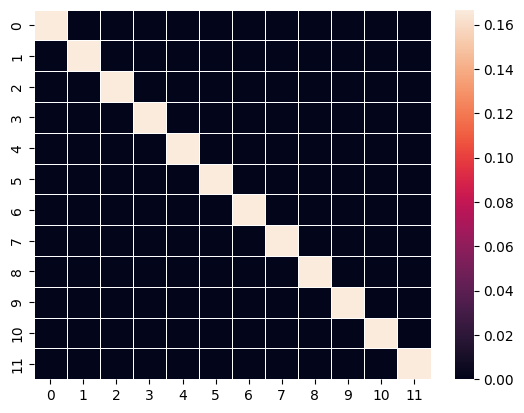

score: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
score heatmap


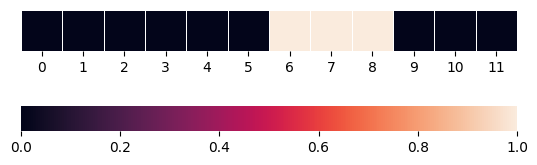

12
0.0
0.0
0.0
0.0
0.0
0.0
higher than 0.9
higher than 0.9
higher than 0.9
0.0
0.0
0.0


In [7]:
for video_name, data in model_score.items():
#     print(video_name)
    if dataset_name == "SumMe":
        if "St Maarten Landing" not in video_name:
            continue
    elif dataset_name == "TVSum": 
        if "0tmA_C6XwfM" not in video_name:
            continue
    print("video:", video_name)
    summary = data['summary']
    score = data['score']
    attn_weights = data['attn_weights'].cpu()
    if dataset_name == "SumMe":
        best_user = data['best_user']
    
    unique, counts = np.unique(summary, return_counts=True)
    values = dict(zip(unique, counts))
    print(values[1] / len(summary))
    
    print(attn_weights.shape)
    
    
    index = video2index[video_name]
    n_frames = np.array(hdf[index]["n_frames"])
    change_points = np.array(hdf[index]["change_points"])
    user_summary = np.array(hdf[index]["user_summary"])
    print("video name:", video_name, index)
    print("num frames:", n_frames)
    print("changepoint:", change_points.shape)
    print("user sum:", user_summary.shape)
    print("attn weight 0:", attn_weights.shape[0])
    print("attn diag:")
    for i in range(attn_weights.shape[0]):
        print(attn_weights[i][i].numpy(), end = " ")
    print("")
    
    print("attn weights:", attn_weights)
    print("attn heatmap")
    ax = sns.heatmap(attn_weights, linewidth=0.5)
    plt.grid(False)
    plt.show()
    print("score:", score)
    print("score heatmap")
    ax = sns.heatmap(np.array(score).reshape((1, -1)), linewidth=0.5, square=True, cbar_kws={"orientation": "horizontal"})
    plt.yticks([])
    plt.grid(False)
    plt.show()
    print(len(score))
    for segscore in score:
        if segscore < 0.9:
            print(segscore)
        else:
            print("higher than 0.9")
    
    
#     print(summary)
    
#     idx = 90
#     step = 30
#     accepted_index = (
#         [i for i in range(0, idx, step)]
#         + [i for i in range(int(n_frames / 2), int(n_frames / 2) + idx, step)]
#         + [i for i in range(n_frames - idx, n_frames, step)]
#     )

#     num_imgs = 10
#     step = int(n_frames / num_imgs)
#     print(step)

#     accepted_index = [i for i in range(0, n_frames, step)]

#     print(accepted_index)

#     count = 0
    
#     parent_path = f"frames/{video_name}/"
#     Path(parent_path).mkdir(parents=True, exist_ok=True)
    
#     video_full_path = os.path.join(video_path, f"{video_name}.mp4")
#     print(video_full_path)
#     video = cv2.VideoCapture(video_full_path)
#     print("opened!")
#     while True:
#         success, image = video.read()
#         if success:
#             if count in accepted_index:
#                 img_name = parent_path + video_name + "_" + str(count) + ".jpg"
#                 print(f"save img {img_name}")
#                 cv2.imwrite(img_name, image)
#         else:
#             break
#         count += 1

#         if video.get(cv2.CAP_PROP_POS_FRAMES) == video.get(
#             cv2.CAP_PROP_FRAME_COUNT
#         ):
#             # If the end of the video has been reached, break out of the loop
#             break

#     video.release()
#     cv2.destroyAllWindows()
#     print("closed!")

In [ ]:
# VD: sigma=0,3, các giá trị sẽ đối xứng qua 0.3 đểloss = 0, sigma=0.9 thì các giá trị sẽ đối xứng nhau qua 0.9
# Điểm yếu: không đẩy bật được score của segment được chọn và không được chọn

In [33]:
sum_all = 0
for segscore in score:
    sum_all += segscore
    
print(sum_all/21)

0.1928779866014208
